In [18]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/kaggle/Player-Contact-Detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/kaggle/Player-Contact-Detection


In [19]:
!pip install scikeras[tensorflow]
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:00


In [20]:
import itertools
import keras
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tensorflow_addons as tfa
from tqdm.notebook import tqdm

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef as mcc

In [21]:
tf.__version__

'2.11.0'

In [22]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [23]:
import os, sys
from pathlib import Path

# Set up path
if os.getcwd() == '/content':
    base_path = Path('__file__').resolve().parent.parent
else:
    base_path = Path().resolve()

data_path = base_path / 'data'
submission_path = base_path / 'submission'
print(data_path)

/content/drive/MyDrive/Colab Notebooks/kaggle/Player-Contact-Detection/data


# Load Fully-Connected train-test dataset

In [24]:
submission = pd.read_csv(data_path / 'sample_submission.csv')

def make_filename(windows: int=0, test: bool=False, ground: bool=False):
    train_test = 'test' if test else 'train'
    type_ = 'ground' if ground else 'player'

    filename = f'{train_test}_{type_}_contact_tracking'

    if windows == 0:
        suffix = '.csv'
    elif windows >= 1:
        suffix = f'_{windows}.csv'

    return filename + suffix

def load_data(data_path, windows: int=0, ground: bool=False):
    train_filename = make_filename(windows, test=False, ground=ground)
    test_filename = make_filename(windows, test=True, ground=ground)

    try:
        train = pd.read_csv(data_path / train_filename)
        test = pd.read_csv(data_path / test_filename)

    except Exception as e:
        print("Return basic dataset.")
        load_data(data_path, 0)
    
    train.sort_values(by=['group_id', 'step'], inplace=True)
    train.reset_index(drop=True, inplace=True)
    test.sort_values(by=['group_id', 'step'], inplace=True)
    test.reset_index(drop=True, inplace=True)

    return train, test

# Imbalance Processing

In [25]:
def preprocessing(data):
    temp = data.loc[data.contact == 1]
    index = temp.index.values.tolist()

    prev_i = index[0]
    group_ids = []

    for i in index:
        if (i - prev_i) > 1:
            sr = data.loc[prev_i,:]
            group_id = sr.loc['group_id']
            group_ids.append(group_id)
        prev_i = i
    
    drop_cols = ['contact_id', 'group_id', 'game_play',
                 'step', 'nfl_player_id_1', 'nfl_player_id_2']

    result = data.loc[data.group_id.isin(group_ids), :]
    result.drop(columns=drop_cols, inplace=True)
    return result

# Transformer

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [27]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [28]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [29]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [30]:
def transformer():
    embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
    num_heads = 2  # 어텐션 헤드의 수
    dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기
    max_len = 12  # 문장의 최대 길이
    vocab_size = 128  # 빈도수 상위 2만개의 단어만 사용

    inputs = tf.keras.layers.Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
    x = embedding_layer(inputs)

    x = tf.keras.layers.Conv1D(filters = 64, kernel_size = 2, padding='valid', activation='relu')(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)

    #print(x.shape)
    #transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
    transformer_block = TransformerBlock(64, num_heads, dff)
    x = transformer_block(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    #x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    adam = tf.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer=adam,
                  loss="binary_crossentropy",
                  metrics=['accuracy',
                           tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)])
    return model

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
def model_result(train: pd.DataFrame, test: pd.DataFrame,
                 windows: int, epochs: int=100,
                 batch_size: int=128, ground: bool=False) -> pd.DataFrame:

    drop_cols = ['contact_id', 'group_id', 'game_play',
                 'step', 'nfl_player_id_1', 'nfl_player_id_2']
    target_column = 'contact'

    X = train.drop(columns=[target_column])
    y = train.contact

    X_test = test.drop(columns=drop_cols + [target_column])

    # train, validation dataset split
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42)

    # model initializing
    model = KerasClassifier(model=transformer, epochs=epochs,
                            batch_size=batch_size, verbose=1)
    model._estimator_type="classifier"
    
    # model training
    model.fit(X_train, y_train)
    
    # # Find optimized parameters(batch size and epochs)
    # params = {
    # 'batch_size':[256, 512, 1024],
    # 'epochs':[60, 90, 120, 150],
    # }
    
    # grid = GridSearchCV(model, param_grid=params, cv=3, refit=True)
    # grid.fit(X_train, y_train)
    # print(grid.best_params_)
    
    # prediction
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_val)

    score_train = mcc(y_train, y_train_pred)
    score_val = mcc(y_val, y_pred)
    print("Train mcc score is %.4f" % (score_train))
    print("Validation mcc score is %.4f" % (score_val))

    y_test = model.predict(X_test)

    test.loc[:, target_column] = y_test
    return test.loc[:, ['contact_id', target_column]], score_val

# Inference

In [49]:
def inference(windows):
    train_player, test_player = load_data(data_path, windows, ground=False)
    train_ground, test_ground = load_data(data_path, windows, ground=True)

    train_player_balanced = preprocessing(train_player)
    train_ground_balanced = preprocessing(train_ground)
    
    # Calculate the number of samples in each class
    class_0 = len(train_player_balanced.query('contact == 0'))
    class_1 = len(train_player_balanced.query('contact == 1'))
    print(f"Class ratio is {class_1 / class_0}")

    # Plot the class distribution
    plt.bar(['Class 0', 'Class 1'], [class_0, class_1], color=['red', 'blue'])
    plt.xlabel('Class Label')
    plt.ylabel('Number of Samples')
    plt.title('Class Imbalance Plot')
    plt.show()

    print(f'train_player shape: {train_player_balanced.shape}')
    print(f'train_ground shape: {train_ground_balanced.shape}')

    print(f'#----------------- Windows: {str(windows): <2s}-------------------#')
    print('#------ Model: contact between players -----#')
    player, score_player = model_result(train_player_balanced, test_player, windows)
    print()
    print('#------ Model: contact player-ground -------#')
    ground, score_ground = model_result(train_ground_balanced, test_ground, windows, ground=True)
    print('#-------------------------------------------------#')
    print()
    # score_ls.append((score_player, score_ground))
    result = pd.merge(submission.loc[:, 'contact_id'],
                      pd.concat([player, ground]),
                      on='contact_id', how='left')
    return result

# Submission

In [50]:
def save_submission(submission, windows):
    num = 1
    try:
        for fname in os.listdir(submission_path):
            if f'submission_transformer_win{windows}' in fname:
                num += 1
    except FileNotFoundError:
        num = 1

    filename = f'submission_transformer_win{windows}_ver{num}.csv'
    submission.to_csv(base_path / 'submission' / filename, index=False)

# Main.py

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Class ratio is 0.2172030576333845


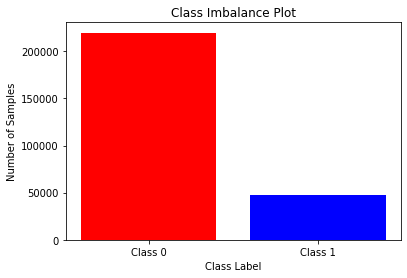

train_player shape: (267355, 13)
train_ground shape: (52391, 13)
#----------------- Windows: 3 -------------------#
#------ Model: contact between players -----#
Epoch 1/100
1671/1671 [==============================] - 30s 15ms/step - loss: 0.2332 - accuracy: 0.8945 - MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/100
1671/1671 [==============================] - 24s 14ms/step - loss: 0.2227 - accuracy: 0.8986 - MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/100
1671/1671 [==============================] - 23s 14ms/step - loss: 0.2213 - accuracy: 0.8986 - MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 4/100
1671/1671 [==============================] - 19s 12ms/step - loss: 0.2200 - accuracy: 0.8991 - MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 5/100
1671/1671 [==============================] - 22s 13ms/step - loss: 0.2188 - accuracy: 0.8998 - MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 6/100
1671/1671 [==============================] - 20s 12ms/step - loss: 0.2182 - 

In [ ]:
window = 3
submission = inference(window)
submission

In [ ]:
save_submission(submission, window)

In [ ]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'Shell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

is_notebook()

In [ ]:
get_ipython().__class__.__name__